In [1]:
from __future__ import print_function, division
import numpy as np
import thinkstats2
import thinkplot
import nsfg

In [2]:
# 准备数据
preg = nsfg.ReadFemPreg(dct_file='datasets/2002FemPreg.dct',  dat_file='datasets/2002FemPreg.dat.gz')
live = preg[preg.outcome == 1]

firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

# 04. 累积分布函数
本章代码位于`cumulative.py`中。

## 4.1 PMF的局限
PMF适用于变量值数量较少的情况。但是随着值的数量增加，每个值对应的概率会变得越来越小，随机噪音的影响就会变大。

例如，我们可能对新生儿的体重分布感兴趣。在全国家庭增长调查的数据中，变量`totalwgt_lb`记录了新生儿的体重，单位为磅。`图4-1`展示了第一胎新生儿和其他胎变量`totalwgt_lb`的PMF：

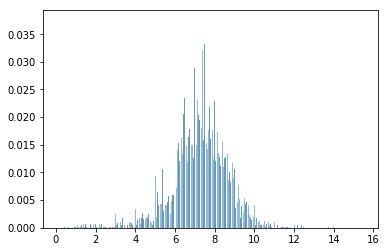

In [3]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()

other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

width = 0.4 / 16

thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)

我们很难对这个图形中的某些部分进行解释。图中有很多的`尖峰`和`低谷`，而且两个分布有明显差别。从图中我们很难分辨哪些特征是有意义的，而且也不容易看出整体模式，如哪个分布的均值更高。

避免上述问题的一个方法是使用`累积分布函数`（cumulative distribution function，CDF）。在此之前，我们需要了解百分位数。

## 4.2 百分位数
如果你参加过标准化考试，得到的结果可能是`原始成绩`和`百分位秩`（percentile rank）。`百分位秩`是比你成绩低（或相同）的人的比例。因此，如果你`位于第90百分位`，就说明你的成绩高于或等于90%参加考试的人。

要计算序列`scores`中的一个值`your_score`的百分位秩，可以使用如下代码：

In [4]:
def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

如果序列中的成绩值为56、66、77、88和99，你的成绩是88，那么你的百分位秩就是$100*\frac{4}{5}$，即80。

如果给定一个百分位秩，要找出其对应的值，可以对值排序，并进行查找：

In [5]:
def Percentile(scores, percentile_rank):
    scores.sort()
    for score in scores:
        if PercentileRank(scores, score) >= percentile_rank:
            return score

这个计算的结果是一个`百分位数`（percentile）。例如，在之前给出的考试成绩分布中，第50百分位数是77。

`Percentile`的实现方法性能欠佳。更好的方法是使用百分位秩计算相应的百分位数索引：

In [6]:
def Percentile2(scores, percentile_rank):
    scores.sort()
    index = percentile_rank * (len(scores)-1) / 100
    return scores[index]

`百分位数`和`百分位秩`的概念容易混淆，常有人用错。

## 4.3 CDF
理解百分位数和百分位秩的概念后，就可以开始讨论`累积分布函数`（cumulative distribution function，CDF）了。CDF将一个值映射到百分位秩。

CDF是$x$的函数，其中$x$是可能出现在分布中的任意值。要获得某个特定值$x$的$\rm CDF(x)$，我们需要计算出小于或等于$x$的值在此分布中所占的比例：

In [7]:
def EvalCdf(t, x):
    count = 0.0
    for value in t:
        if value <= x:
            count += 1
    prob = count / len(t)
    return prob

sample = [1, 2, 2, 3, 5]

for x in range(0, 7):
    print("x = %d, CDF(x) = %f"% (x, EvalCdf(sample, x)))

x = 0, CDF(x) = 0.000000
x = 1, CDF(x) = 0.200000
x = 2, CDF(x) = 0.600000
x = 3, CDF(x) = 0.800000
x = 4, CDF(x) = 0.800000
x = 5, CDF(x) = 1.000000
x = 6, CDF(x) = 1.000000


我们可以为任意值$x$计算CDF，而不仅限于样本中出现的值：
+ 如果$x$小于样本中的最小值，那么$\rm CDF(x)$为0
+ 如果$x$大于样本中的最大值，那么$\rm CDF(x)$为1

下图展示了这个CDF函数。一个样本的CDF是一个阶梯函数：

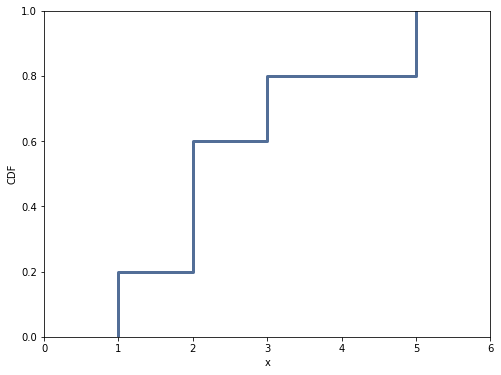

<Figure size 576x432 with 0 Axes>

In [8]:
t = [2, 1, 3, 2, 5]
cdf = thinkstats2.Cdf(t)
thinkplot.Clf()
thinkplot.Cdf(cdf)
thinkplot.Show(root='cumulative_example_cdf', xlabel='x', ylabel='CDF',
                   axis=[0, 6, 0, 1], legend=False) 

## 4.4 表示CDF
`thinkstats2`中有一个表示CDF的类`Cdf`。`Cdf`提供如下基本方法：
+ `Prob(x)`：对给定的值$x$，计算其概率$p=\rm CDF(x)$。方括号操作符等同于Prob方法
+ `Value(p)`：对给定的概率$p$，计算对应的值$x$，即$p$的CDF反函数

下面的代码创建了全国家庭增长调查中妊娠期时间分布的Cdf：

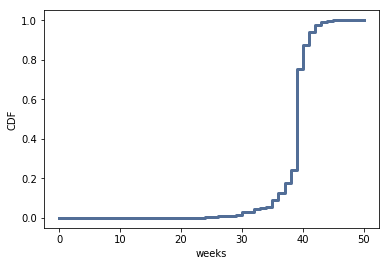

<Figure size 576x432 with 0 Axes>

In [9]:
cdf = thinkstats2.Cdf(live.prglngth, label='prglngth')
thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='weeks', ylabel='CDF')

上图展示了绘制结果。解读CDF的方法之一是寻找其百分位数。例如，从图中我们可以看出，大约10%的妊娠期不超过35周，大约90%不超过41周。CDF还展现了分布的形状。分布中经常出现的值在CDF中显示为陡峭或竖直的折线。图中可以明显看出位于39周的众数。图中小于30周的值很少，因此30周左侧的折线很平缓。

熟悉CDF可能需要一定的时间，但一旦了解，你就会发现CDF比PMF展示的信息更多，也更清晰。

## 4.5 比较CDF
在进行分布比较时，CDF尤为有用。下图比较了第一胎和其他胎新生儿体重的CDF：

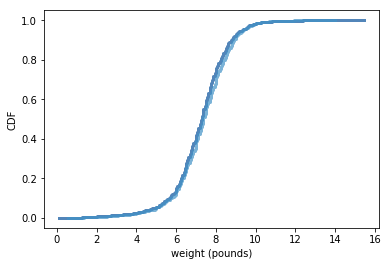

<Figure size 576x432 with 0 Axes>

In [10]:
first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label='first')
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label='other')

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Show(xlabel='weight (pounds)', ylabel='CDF')

## 4.6 基于百分位数的统计量
计算出CDF之后，就很容易计算出`百分位数`和`百分位秩`。Cdf类为此提供了两个方法：
+ `PercentileRank(x)`：对给定的值$x$，计算其百分位秩，即$100 \cdot \rm CDF(x)$
+ `Percentile(p)`：对给定的百分位秩rank，计算对应的值$x$。等价于$\rm Value(\frac{p}{100})$

Percentile可以用于计算基于百分位数的汇总统计量。例如，第50百分位是将一个分布划分为两部分的值，也称为`中位数`。

另一个基于百分位数的统计量是`四分位距`（interquartile range，IQR），用于度量一个分布的展布。四分位距是第75百分位和第25百分位的差值。

通常情况下，百分位数还用于对分布的形状进行简要描述。例如，人们经常用`五等份分组`描述收入分布，即按第20、40、60和80百分位数来分组。其他分布则划分为`十等份`。这种CDF中的等份点称为`分位数`（quantile）。关于[分位数的更多信息](https://en.wikipedia.org/wiki/Quantile)。

## 4.7 随机数
假设我们要从成功生产的总体中选择一个随机样本，并查找样本中新生儿体重的百分位秩，这个分布会是什么样的呢？

为计算这个分布，首先要创建新生儿体重的Cdf：

In [11]:
weights = live.totalwgt_lb
cdf = thinkstats2.Cdf(weights, label='totalwgt_lb')

生成一个样本并计算样本中每个值的百分位秩 :

In [12]:
sample = np.random.choice(weights, 100, replace=True)
ranks = [cdf.PercentileRank(x) for x in sample]

`sample`是新生儿体重的一个随机样本，样本大小为100，使用`放回`（replacement）抽样，即同一个值可以选择多次。`ranks`是百分位秩的一个列表：

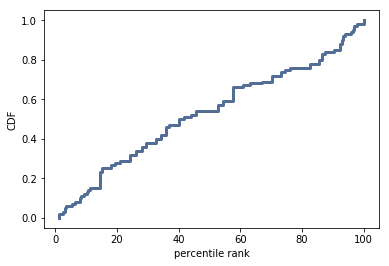

<Figure size 576x432 with 0 Axes>

In [13]:
rank_cdf = thinkstats2.Cdf(ranks)
thinkplot.Cdf(rank_cdf)
thinkplot.Show(xlabel='percentile rank', ylabel='CDF')

这个结果可能不那么明显，但这是由CDF的定义方式决定的。这个图形显示，样本中10%的值小于第10百分位数，20%的值小于第20百分位数，以此类推，完全符合预期。

因此，无论CDF的形状如何，其百分位秩的分布都是均匀的。这个属性非常有用，可以作为一种简单有效算法的基础，使用给定的CDF生成随机数。具体方法如下：
+ 从0到100中均匀地选择一个百分位秩
+ 使用Cdf.Percentile，得到分布中对应所选百分位秩的值

Cdf提供一个方法Random，可实现上述算法：
```python
# cass Cdf:
   def Random(self):
       return self.Percentile(random.uniform(0, 100))
```

Cdf还提供一个方法`Sample`，其参数为整数$n$，返回从Cdf中随机选择的$n$个值列表。

## 4.8 比较百分位秩
百分位秩可以用来比较不同群组之间的度量值。例如，跑步比赛的选手通常按年龄和性别分组。要比较不同年龄组的选手，可以将比赛成绩转换成百分位秩。

例如，我参加了10公里比赛，成绩为42:44，在1633名选手中排名97。我超过或平了1633名选手中的1537名，因此在整个比赛中的百分位秩为94%。

给定排名和参赛人数，我们可以计算出百分位秩：

In [14]:
def PositionToPercentile(position, field_size):
    beat = field_size - position + 1
    percentile = 100.0 * beat / field_size
    return percentile

我所在年龄组为M4049，即`40~49岁的男性`。在256名选手中排名26。因此，我在所属年龄组中的百分位秩为90%。

如果10年之后我还在跑步，将会分在M5059组中。假设我在所属年龄组中的百分位秩依然不变，那么会比现在的成绩慢多少？

要回答这个问题，我可以将自己在M4049中的百分位秩转换成M5059中的排名，从而得到答案。实现代码如下：

In [15]:
def PercentileToPosition(percentile, field_size):
    beat = percentile * field_size / 100.0
    position = field_size - beat + 1
    return position

M5059组中有171名选手，因此我的成绩必须位于第17位或第18位成绩之间才能保持现在的百分位秩。M5059组中第17名的比赛成绩是46:05，所以我必须跑进46:05才能保持90%的百分位秩。